My work in the previous few notebook has shown that naive MCMC will not work for this problem; the scale is too large. It has been suggested that importance sampling may hold the answer. I'm going to start by sampling some mock data, then attempting to importance sample its parameters.

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
colors = sns.color_palette()
import numpy as np
np.random.seed(0)#"Random"

In [30]:
#First, will need the parameters
redshift = .9 #one redshift, for now. 
nSamples = 1000
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0e14, 1.0e14]
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

#interpolates naively between the points given in the original paper
z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)

#return the values of the parameters at a given z. 
getMassParams = lambda z : {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

def log_n_approx(m,z):
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [31]:
#use MCMC to sample masses from the mass function
import emcee as mc
ndim = 1
nWalkers = 1000
nSteps = 500
nBurn = 400
nCores = 1

Mmin, Mmax = 1e13, 5e15
pos0 = np.random.uniform(np.log10(Mmin), np.log10(Mmax), size = nWalkers).reshape((nWalkers, ndim))

def log_p(logM, z):
    logM = logM[0]
    m = 10**logM
    if m>Mmax or m<Mmin:
        return -np.inf
    
    return log_n_approx(m, z)

sampler = mc.EnsembleSampler(nWalkers, ndim, log_p, args=[redshift],threads = nCores)

In [32]:
sampler.run_mcmc(pos0, nSteps);

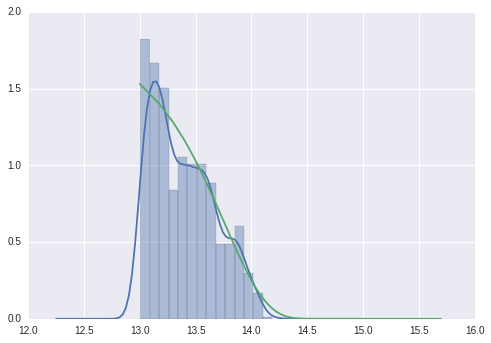

In [33]:
logMSamples = sampler.chain[:,nBurn:, :].reshape((-1, nSamples))[0,:]
mSamples = 10**logMSamples
sns.distplot(logMSamples)

x = np.linspace(Mmin,Mmax,1000)
#contstant mulitple is because seaborn normalizes the hist
plt.plot(np.log10(x),1.7*n_approx(x, redshift), color = colors[1])
plt.show()

Looks good! Go MCMC. 

In [34]:
M_piv = 2.35e14
logL0_true = 3.141
a_true, b_true = 0.842, -0.03
B_l_true = 0.642
sigma_l_true = 0.184

_A_lam = lambda a,b,z : a*pow((1+z)/1.3, b)

from scipy.stats import norm
from scipy.stats import multivariate_normal as mv_norm
#forward model
def logLam(logLam0, a, b, B_lam, z, M):
    A_lam = _A_lam(a,b,z)
    return logLam0+A_lam*np.log(M/M_piv)+B_lam*np.log((1+z)/1.3)

def logLamSample(logLam0, a, b, B_lam,sigma_lam, z,M):
    return norm.rvs(loc = logLam(logLam0, a, b, B_lam, z, M), scale = sigma_lam, size = M.shape[0])

In [35]:
logRichness = logLamSample(logL0_true, a_true, b_true, B_l_true, sigma_l_true, redshift, mSamples)

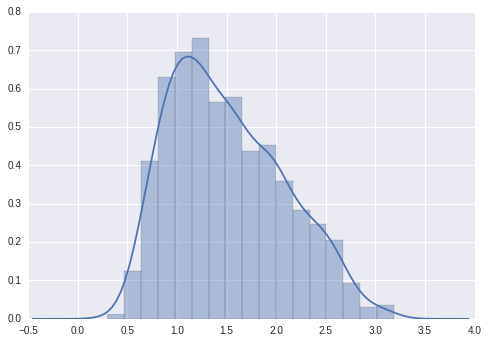

In [36]:
sns.distplot(logRichness)

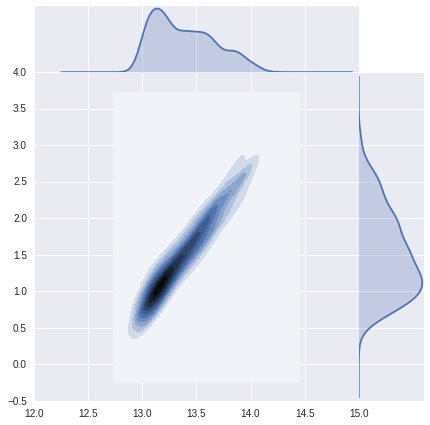

In [37]:
sns.jointplot(logMSamples, logRichness, kind = 'kde', stat_func = None, space = 0)

Ok, this all looks decent. Sampling with MCMC is the way to go. If you go back up (as I did earlier) and take more mass samples, this looks more or less perfect. I suppose I'm not sure what amount of "data points" I'd like to have for this; maybe 1000 is too small. It's easy enough to change later if I decide to. Okay, now to work on importance sampling. 

I'm trying to start with something simple. So, I will sample masses from our model given a good guess at the parameters (in this case, the true params). 

In [42]:
from scipy.stats import gamma, norm, expon
#TODO I've relaxed a few priors, I could stand to strengthen them back up again. 
def log_prior(logL0, a,b,B_l, sigma):
    
    if any(x<0 for x in (logL0,sigma)):
        return -np.inf

    t1 = np.arctan(B_l)
    t2 = np.arctan(a)
    #if t<0 or t>np.pi/2:
    if any(x< -np.pi/2 or x> np.pi/2 for x in (a,B_l)):
        return -np.inf
    
    #Hyperparameters
    lambda_logL0 = 1.0
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in logL0
    p+= expon.logpdf(logL0, scale = 1/lambda_logL0)
    #Uniform in arctan(B_l) and arctan(a)
    p+=2*np.log(1/np.pi)
    #flat prior for b
    #Have not idea what it would be, start with nothing
    #p+=0
    
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma**2,sigma_a, scale = sigma_b)
    return p

#returns a logmass given a richness
def invLogLam(logLam0, a, b, B_lam, z, logRich):
    A_lam = _A_lam(a,b,z)
    return np.log(M_piv)+(logRich-logLam0-B_lam*np.log((1+z)/1.3))/A_lam
#TODO Make this one synonymous with it non-inverse version
#TODO Consider checking if logRich is a vector or a number, and acting accodingly. 
def invLogLamSample(logLam0, a, b, B_lam,sigma_mass, z,logRich, size = 100):
    mu = invLogLam(logLam0, a, b, B_lam, z, logRich)
    #return mv_norm.rvs(mean = mu, cov = sigma_mass*np.identity(logRich.shape[0]), size =  size).T#(logRich.shape[0], size)
    return norm.rvs(loc = mu, scale = sigma_mass, size =  size)#( size,)
    
from scipy.misc import logsumexp
def log_liklihood(logL0, a,b, B_l, sigma, z, logRich):
    sigma_mass = 1 #TODO idk what this should be; i suppose it's my discretion, or some relation to
    logL = 0
    #TODO Vectorize furhter?
    
    for lr in logRich:
        #use truths as really really good guess. Can relax later. 
        massSamples = invLogLamSample(logL0_true, a_true, b_true, B_l_true,sigma_mass, z, lr)

        logPRich = norm.logpdf(lr, loc =logLam(logL0, a, b, B_l, z, massSamples), scale = sigma)
        logPMass = log_n_approx(massSamples,z)
        logPMass_sample = norm.logpdf(massSamples, loc = invLogLam(logL0_true, a_true, b_true, B_l_true, z, lr), scale = sigma_mass)
        
        logL+= logsumexp(logPRich+logPMass-logPMass_sample)
        
    return logL
    
    '''
    massSamples = invLogLamSample(logL0_true, a_true, b_true, B_l_true,sigma_mass, z, logRich)
    print massSamples.shape
    logPRich = logsumexp([norm.logpdf(logRich[i], loc =logLam(logL0, a, b, B_l, z, massSamples[i, :]), scale = sigma)\
                         for i in xrange(logRich.shape[0])], axis = 1)
    logPMass = np.sum(log_n_approx(massSamples,z), axis = 1)
    logPMass_sample = norm.logpdf(massSamples, loc = invLogLam(logL0_true, a_true, b_true, B_l_true, z, logRich), scale = sigma_mass)
    '''
def log_posterior(theta,z, logRich):
    #print theta
    logL0,a,b, B_l, sigma = theta[:]
    p = log_prior(logL0, a,b, B_l, sigma)
    if np.isfinite(p):
        p+=log_liklihood(logL0,a,b, B_l, sigma, z, logRich)
    return p

In [43]:
%%timeit
print log_posterior([logL0_true, a_true, b_true, B_l_true, sigma_l_true], redshift, logRichness)

-7643692.37927
-7643604.6559
-7644029.84932
-7643677.58942
1 loops, best of 3: 391 ms per loop


In [44]:
nCores = 4
nWalkers = 500
nSteps = 100
#set up sampler
nDim = 5

logL0_a, logL0_b = 1, 1 # Gamma
a_mean, a_spread = 1, 1.5
b_mean, b_spread = 0, .5
B_l_mean, B_l_spread = 1, 1.5
sigma_a, sigma_b = 1, 1 #Gamma

pos0 = np.zeros((nWalkers, nDim))
for row in pos0:

    row[0] = gamma.rvs(logL0_a, scale = logL0_b)
    row[1] = norm.rvs(loc = a_mean, scale = a_spread)
    row[2] = norm.rvs(loc = b_mean, scale = b_spread)
    row[3] = norm.rvs(loc = B_l_mean, scale = B_l_mean)
    row[4] = gamma.rvs(sigma_a, scale = sigma_b)

In [45]:
del(sampler)
sampler = mc.EnsembleSampler(nWalkers, nDim, log_posterior, args=[redshift, logRichness],threads = nCores)

In [ ]:
sampler.run_mcmc(pos0, nSteps);

In [ ]:
nBurn = 5
chain = sampler.chain[:,nBurn:, :].reshape((-1, nDim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain[:, :5].mean(axis = 0)

labels = ['logL0', 'a', 'b','B_l','sigma']
print '\tMCMC\tTrue'
for label, val, truth in zip(labels, MAP, [logL0_true, a_true, b_true, B_l_true, sigma_l_true]):
    print '%s:\t%.3f\t%.3f'%(label, val, truth)

In [ ]:
from corner import corner
titles = ['$\log{\lambda_0}$', '$a$', '$b$', '$B_{\lambda}$', '$\sigma$']
corner(chain[:, :5], labels = titles , truths = [logL0_true, a_true, b_true, B_l_true, sigma_l_true]);